In [1]:
import os
import pickle
from os.path import join
from tifffile import imread
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
cwd = os.getcwd()

In [3]:
file = Path("./input/demo.tif")
config_id = 1

In [4]:
experiment = Path(file).stem
data_dir = Path(join(cwd, "output", experiment))
input_file = Path(join(cwd, "input", file.name))


In [5]:
normalized_path = data_dir / "normalized.npy"
cellpose_path = data_dir / "cellpose_labels.npy"
wscp_path = data_dir / "wscp_labels.npy"
stardist_path = data_dir / "stardist_labels.npy"
wssd_path = data_dir / "wssd_labels.npy"
detection_path = data_dir / f"{config_id}" / "detections.npz"
tracks_path = data_dir / f"{config_id}" / "tracks.pkl"
track_label_path = data_dir / f"{config_id}" / "track_labels.npy"
graph_path = data_dir / f"{config_id}" / "graph.pkl"

In [6]:
with open(graph_path, "rb") as f:
	graph = pickle.load(f)

In [159]:
image = imread(input_file)
normalized = np.load(normalized_path)

In [168]:
normalized = normalized.swapaxes(1, 3)

In [171]:
image = image[:, 1:, :, :]

In [8]:
tracks_df = pd.read_pickle(tracks_path)

In [96]:
track_labels = np.load(track_label_path)

In [10]:
BLUE_FLAG = (image.shape[1] > 4)

In [11]:
tracks_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id
id,,,,,,,
1000001,1,0,3.0,461.0,1000001,-1,-1
2000006,1,1,4.0,454.0,2000006,-1,1000001
3000002,1,2,3.0,445.0,3000002,-1,2000006
4000005,1,3,4.0,444.0,4000005,-1,3000002
5000028,1,4,5.0,438.0,5000028,-1,4000005
1000002,2,0,13.0,463.0,1000002,-1,-1
2000004,2,1,12.0,462.0,2000004,-1,1000002
3000005,2,2,9.0,458.0,3000005,-1,2000004
4000013,2,3,7.0,463.0,4000013,-1,3000005


In [12]:
def invert_graph(graph):
	inverse_graph = {}
	for key, value in graph.items():
		if value in inverse_graph.keys():
			inverse_graph[value].append(key)
		else:
			inverse_graph[value] = [key]
	return inverse_graph

In [13]:
def get_lines(tracks_df, graph):
	"""Generator which yields all continuous tracks. It provides
	a single lineage of a track by iterating through its children
	and providing a copy of the parent in front of the children.
	For example, if track 1 has children 2 and 3, the generator 
	will yield a concatanation of track 1 and 2, and then a 
	concatanation of track 1 and 3.

	Args:
		tracks_df (pd.DataFrame): tracks dataframe from ultracks 
			analysis
		graph (dict): hierarchy graph from ultracks analysis

	Yields:
		pd.DataFrame: a subset of dataframe containing a single track
	"""
	all_tracks = tracks_df["track_id"].unique()
	
	igraph = invert_graph(graph)

	all_tracks = all_tracks[np.isin(all_tracks, np.array(list(graph.keys())), invert = True)]

	for track_id in all_tracks:
		track = tracks_df[tracks_df["track_id"] == track_id]
		if track_id in igraph.keys():
			for child_track_id in igraph[track_id]:
				child_track = tracks_df[tracks_df["track_id"] == child_track_id]
				extended_track = pd.concat([track, child_track])
				yield extended_track
		else:
			yield track

In [14]:
len(tracks_df)

5503

In [15]:
def populate_cell_intensities(image, track_labels, tracks_df):
	"""Get the mean of the intensity of each channel for each track.

	Args:
		image (np.ndarray): numpy array of the image of the shape 
			(time, channels, h, w)
		track_labels (np.ndarray): an numpy array of labels generated 
			by ultrack
		tracks_df (pd.DataFrame): tracks dataframe from ultracks analysis

	Returns:
		_type_: _description_
	"""
	columns = ["green_intensity", "red_intensity", "farred_intensity"]
	if BLUE_FLAG:
		columns.append("blue_intensity")
	intensities = pd.DataFrame(columns = columns, index = tracks_df.index)
	for track in tracks_df.itertuples():
		time = track.t

		track_mask = (track_labels[time] == track.track_id)
		intensities.loc[track.id] = {
			"green_intensity": np.mean(image[time, 1][track_mask]),
			"red_intensity": np.mean(image[time, 2][track_mask]),
			"farred_intensity": np.mean(image[time, 3][track_mask])
		}
		if BLUE_FLAG:
			intensities.loc[track.id, "blue_intensity"] = np.mean(image[time, 4][track_mask])
	
	tracks_df = pd.merge(tracks_df, intensities, left_index = True, right_index = True)

	return tracks_df

In [16]:
track_intensity_df = populate_cell_intensities(image, track_labels, tracks_df)

In [96]:
def get_intensity_graph(single_intensity_track):
	"""Generates a line graph of the intensity of each channel. Also 
	indicates when the track was split.

	TODO: Format graph. Normalize y value (might need to change the function call to do this).

	Args:
		single_intensity_track (pd.DataFrame): a subset of the 
			track_intensity_df which contains a single track line. 
			Must contain intensity columns.
	"""
	time = single_intensity_track.t
	green_intensity = single_intensity_track.green_intensity
	red_intensity = single_intensity_track.red_intensity
	farred_intensity = single_intensity_track.farred_intensity
	if BLUE_FLAG:
		blue_intensity = single_intensity_track.blue_intensity

	separation_points = []
	lines = single_intensity_track.track_id.unique()

	for line_idx in lines:
		line = single_intensity_track[single_intensity_track["track_id"] == line_idx]
		if line.iloc[0]["parent_id"] == -1:
			continue
		else:
			separation_points.append(min(line.t))
		
	plt.plot(time, green_intensity, label = "green", color = "green")
	plt.plot(time, red_intensity, label = "red", color = "red")
	plt.plot(time, farred_intensity, label = "farred", color = "purple")
	if BLUE_FLAG:
		plt.plot(time, blue_intensity, label = "blue", color = "blue")
	plt.vlines(separation_points, ymin = 0, ymax = max(green_intensity.max(), red_intensity.max(), farred_intensity.max(), blue_intensity.max() if BLUE_FLAG else 0), color = "black")

In [143]:
def get_tracking_images(image, track_labels, single_track, padding = 10):
	"""Gets a list of images of each cell in the track 
	for each channel.
	
	**or**
	
	Generates a list of images of each cell in the track
	for each channel.

	Args:
		image (np.ndarray): numpy array of the image of the 
			shape (time, channels, h, w)
		single_track (pd.DataFrame): a subset of tracks_df 
			containing a single track line.
	"""
	channels = image.shape[1] + 1
	total_time = len(single_track)
	fig, ax = plt.subplots(channels, total_time, figsize = (15, 5))
	
	for cell in single_track.itertuples():
		time = cell.t

		
		track_mask_idx = np.where(track_labels[time] == cell.track_id)
		track_mask = track_labels[time] == cell.track_id
		ybounds = (
			track_mask_idx[1].min() - padding, 
			track_mask_idx[1].max() + padding
		)
		ybounds = (
			int(max(0, ybounds[0])),
			int(min(image.shape[3], ybounds[1]))
		)
		xbounds = (
			track_mask_idx[0].min() - padding,
			track_mask_idx[0].max() + padding
		)
		xbounds = (
			int(max(0, xbounds[0])),
			int(min(image.shape[2], xbounds[1]))
		)

		print(f"""
Time {time}
Cell is located in {cell.x}, {cell.y}
Calculated image bounds are 
	X bounds: {xbounds[0]}, {xbounds[1]}
	Y bounds: {ybounds[0]}, {ybounds[1]}
		""")

		ax[0][time].imshow(track_mask[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
		ax[1][time].imshow(image[time, 0].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
		ax[2][time].imshow(image[time, 1].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
		ax[3][time].imshow(image[time, 2].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
		if BLUE_FLAG:
			ax[4][time].imshow(image[time, 3].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
	
	plt.show()



In [98]:
def get_track_lengths(tracks_df, graph):
	for track in get_lines(tracks_df, graph):
		yield (track.track_id, len(track))

In [69]:
i = 2
for track in get_lines(track_intensity_df, graph):
	if len(track["track_id"].unique()) > 1:
		i -= 1
		if i == 0:
			single_track = track
			break


Time 0
Cell is located in 354.0, 171.0
Calculated image bounds are 
	X bounds: 160, 183
	Y bounds: 342, 366
	

Time 1
Cell is located in 352.0, 167.0
Calculated image bounds are 
	X bounds: 155, 179
	Y bounds: 339, 365
	

Time 2
Cell is located in 353.0, 169.0
Calculated image bounds are 
	X bounds: 159, 180
	Y bounds: 342, 364
	

Time 3
Cell is located in 349.0, 160.0
Calculated image bounds are 
	X bounds: 148, 174
	Y bounds: 339, 360
	

Time 4
Cell is located in 348.0, 156.0
Calculated image bounds are 
	X bounds: 145, 167
	Y bounds: 336, 362
	


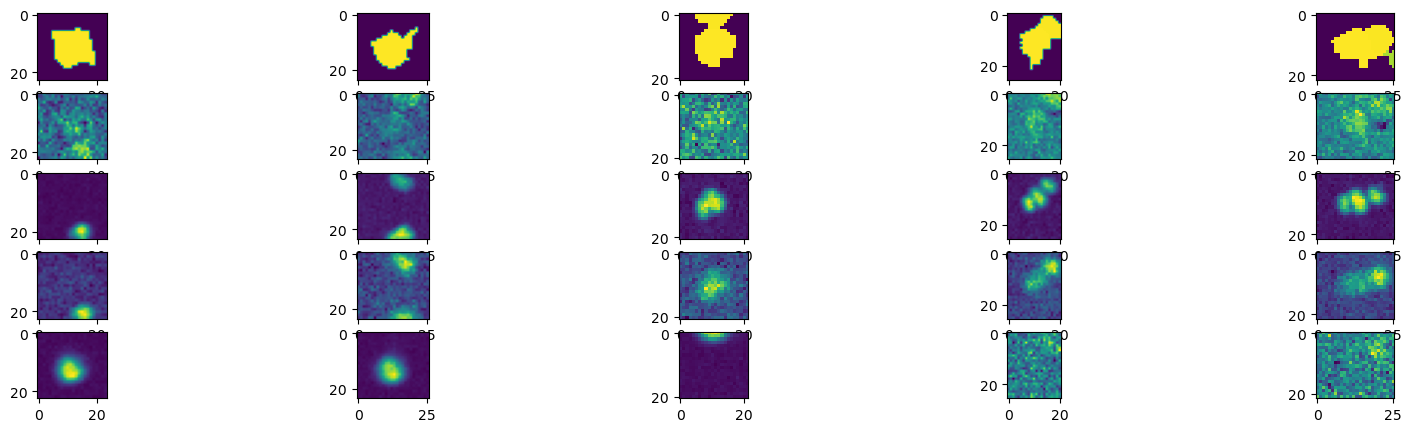

In [178]:
channels = image.shape[1] + 1
total_time = len(single_track)
fig, ax = plt.subplots(channels, total_time, figsize = (20, 5))
padding=5

for cell in single_track.itertuples():
	time = cell.t

	track_mask_idx = np.where(track_labels[time] == cell.track_id)
	track_mask = track_labels[time] == cell.track_id
	ybounds = (
		track_mask_idx[1].min() - padding, 
		track_mask_idx[1].max() + padding
	)
	ybounds = (
		int(max(0, ybounds[0])),
		int(min(image.shape[3], ybounds[1]))
	)
	xbounds = (
		track_mask_idx[0].min() - padding,
		track_mask_idx[0].max() + padding
	)
	xbounds = (
		int(max(0, xbounds[0])),
		int(min(image.shape[2], xbounds[1]))
	)

	print(f"""
Time {time}
Cell is located in {cell.x}, {cell.y}
Calculated image bounds are 
	X bounds: {xbounds[0]}, {xbounds[1]}
	Y bounds: {ybounds[0]}, {ybounds[1]}
	""")
	
	ax[0, time].imshow(track_labels[time][xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
	ax[1, time].imshow(image[time, 0].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
	ax[2, time].imshow(image[time, 1].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
	ax[3, time].imshow(image[time, 2].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])
	if BLUE_FLAG:
		ax[4, time].imshow(image[time, 3].T[xbounds[0]:xbounds[1], ybounds[0]:ybounds[1]])



Time 0
Cell is located in 354.0, 171.0
Calculated image bounds are 
	X bounds: 165, 178
	Y bounds: 347, 361
		

Time 1
Cell is located in 352.0, 167.0
Calculated image bounds are 
	X bounds: 160, 174
	Y bounds: 344, 360
		

Time 2
Cell is located in 353.0, 169.0
Calculated image bounds are 
	X bounds: 164, 175
	Y bounds: 347, 359
		

Time 3
Cell is located in 349.0, 160.0
Calculated image bounds are 
	X bounds: 153, 169
	Y bounds: 344, 355
		

Time 4
Cell is located in 348.0, 156.0
Calculated image bounds are 
	X bounds: 150, 162
	Y bounds: 341, 357
		


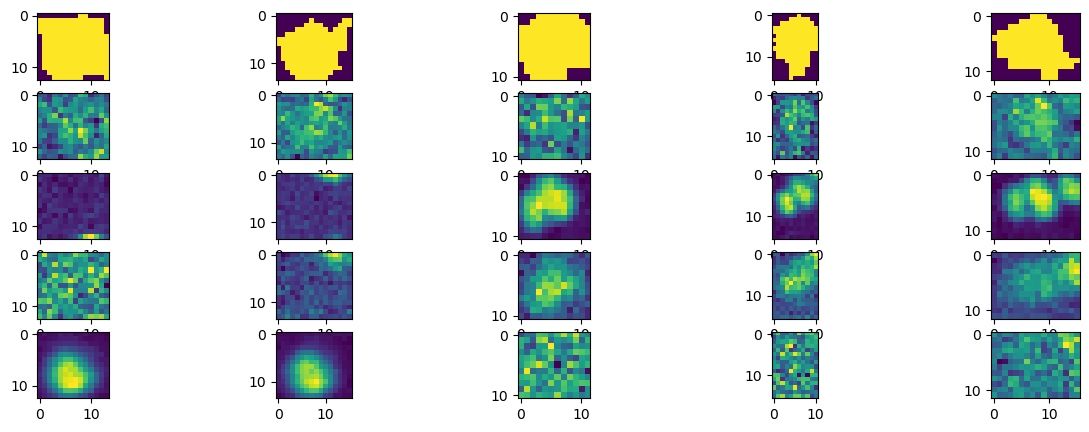

In [145]:
get_tracking_images(image, track_labels, single_track, padding=0)

In [144]:
get_intensity_graph(single_track)

NameError: name 'get_intensity_graph' is not defined